In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from models.TGNet import TGNet
%matplotlib inline

Using TensorFlow backend.


In [2]:
class args_class:
    def __init__(self):
        self.lr = 0.01
        self.decay = 0.01
        self.batch = 128
        self.drop_p = 0.5
        self.epoch = 2000
        self.output_dir = './output/'
        self.save_dir = './/model_saved/'
        self.scale = 'min_max'
        self.dataset_name = 'NYC'
        self.thr = 10
        self.alpha = 0.05
        self.num_gpu = 1
        self.coord = 25.0
        self.nf=32
        self.tge = False
        self.dataset = './NYC_taxi_dataset/'
        self.input_shape = [10,20,8]  
        self.tge = True
        self.temp = 16
        self.coord_net = 2
        self.reg = 0.0
        self.patience = 150
        self.es = 'min'
        self.model_name = 'tge_analyzer'
    def set_tge(self, value):
        self.tge = value

In [3]:
from models.TGNet_NYC import TGNet
import keras
args = args_class()
args.model_name = '06115c5c-9c6b-4b15-b391-1d7ff350c2eb'
model = keras.models.load_model(args.save_dir+args.model_name+'.h5')
model.summary()

from models.model import *

class TGE_Model(BaseModel):
    def build_model(self, input_shape, tge=False):
        temporal_input = Input(shape=(57,))
        input_tensors = [temporal_input]
        
        net_temp = Dense(16, activation='relu')(temporal_input)
        self.net_temp = Dense(16)(net_temp)
        model = Model(inputs=temporal_input, outputs=self.net_temp)
        print (model.summary())
        return model

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 57)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 16)           928         input_3[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 16)           272         dense_1[0][0]                    
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 200, 16)      0           dense_2[0][0]                    
__________________________________________________________________________________________________
input_1 (I

/usr/local/lib/python3.5/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [4]:
TGE = TGE_Model(args.input_shape, args)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 57)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                928       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
Total params: 1,200
Trainable params: 1,200
Non-trainable params: 0
_________________________________________________________________
None


## Temporal Guided Embedding Visualization

In [5]:
tge_weights = model.get_layer('dense_1').get_weights()
tge_weights2 = model.get_layer('dense_2').get_weights()

TGE._model.get_layer('dense_1').set_weights(tge_weights)
TGE._model.get_layer('dense_2').set_weights(tge_weights2)

In [24]:
tge_train = np.load('./NYC_taxi_dataset/temporal_train.npz')['arr_0']
tge_test = np.load('./NYC_taxi_dataset/temporal_test.npz')['arr_0']

In [25]:
tge_train_df = pd.DataFrame(tge_train)
tge_test_df = pd.DataFrame(tge_test)

train_sample = tge_train_df.drop_duplicates()
test_sample = tge_test_df.drop_duplicates()
_train_value = train_sample.values

In [26]:
day_of_week = np.argmax(train_sample.iloc[:,:7].values, axis=1)
time_of_day = np.argmax(train_sample.iloc[:,7:7+48].values, axis=1)
holiday = train_sample.iloc[:,-1]

In [28]:
train_sample.head()
#column: 0~6 (day-of-week), 7~54 (time-of-day), 55: the day before holiday, 56: holiday

,0,1,2,3,4,5,6,7,8,9,...,47,48,49,50,51,52,53,54,55,56
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [30]:
train_sample2 = train_sample[(train_sample[1] !=1) + (train_sample[2] !=1) ]
_train_value2 = train_sample2.values

/usr/local/lib/python3.5/dist-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


In [31]:
_train_value = train_sample.values

In [32]:
_train_value2

array([[1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 1.]])

In [33]:
#temporal guided embedding prediction
train_value = TGE._model.predict(x=_train_value2)

In [34]:
LR = 1000
tsne = TSNE(n_components=2, learning_rate=LR)#, perplexity=10)

In [35]:
transformed = tsne.fit_transform(train_value)

(464, 2)


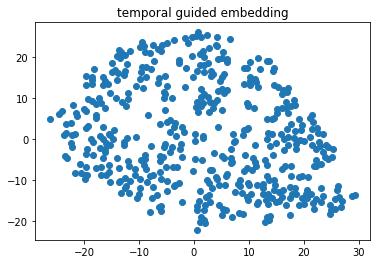

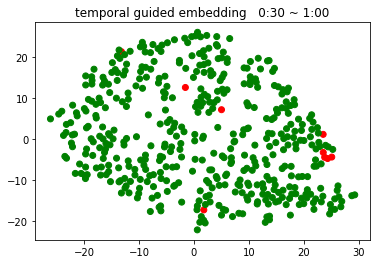

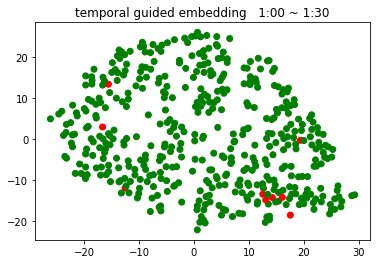

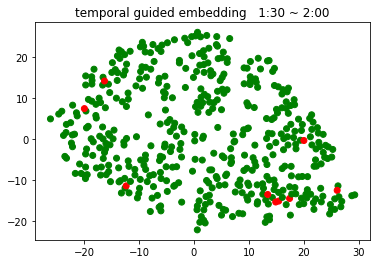

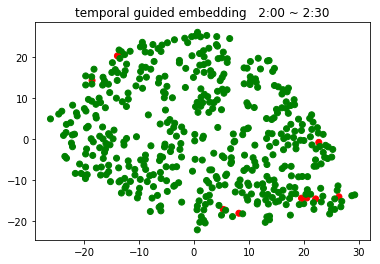

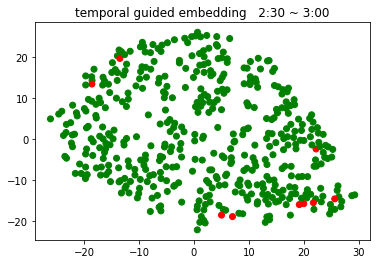

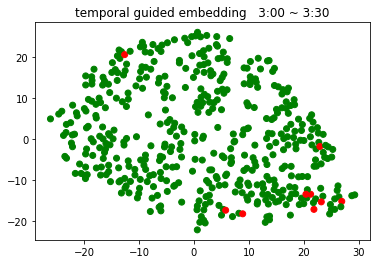

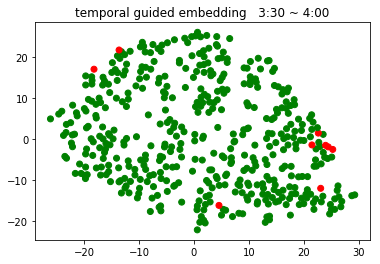

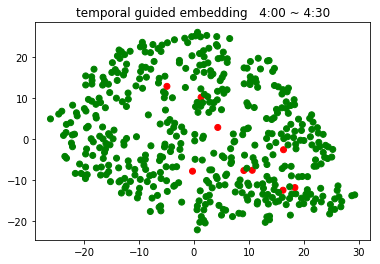

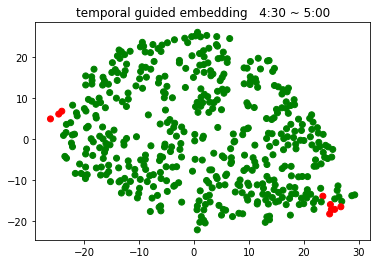

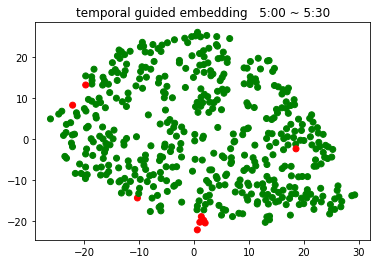

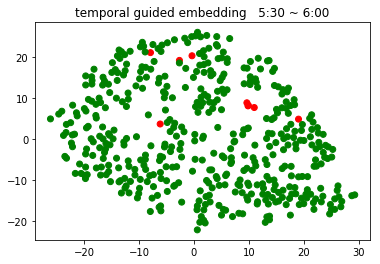

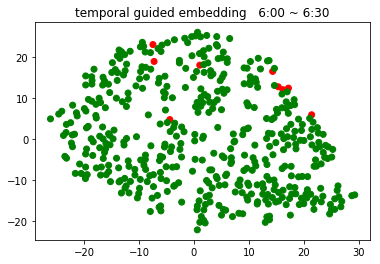

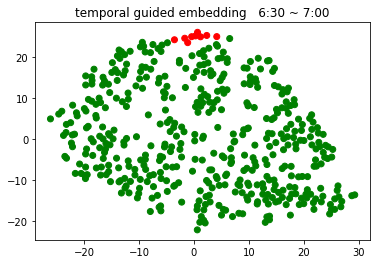

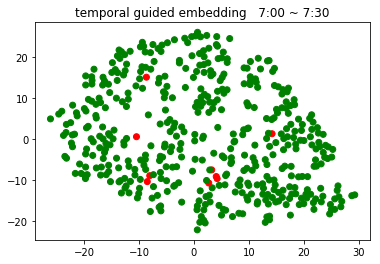

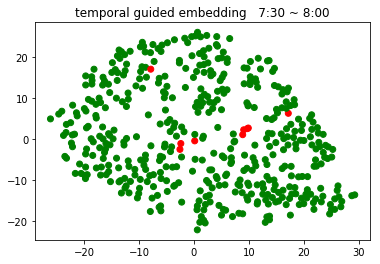

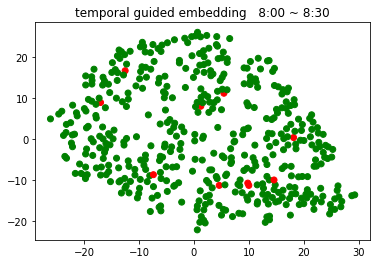

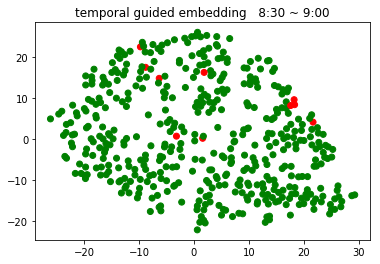

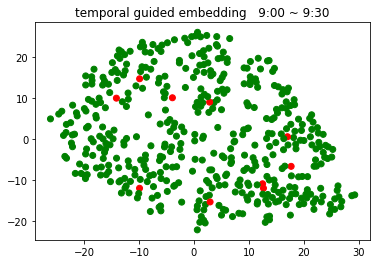

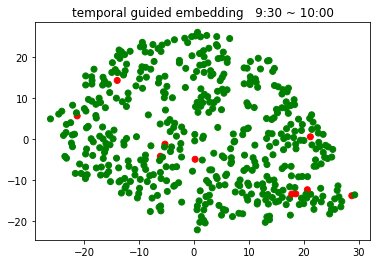

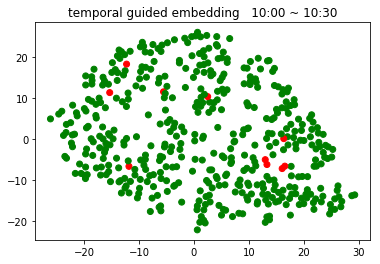

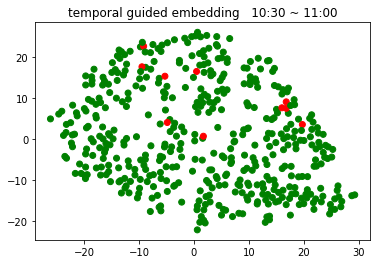

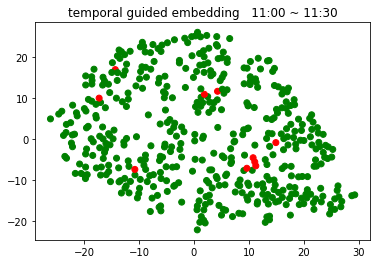

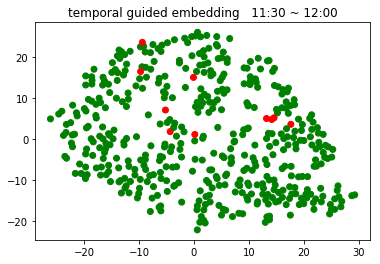

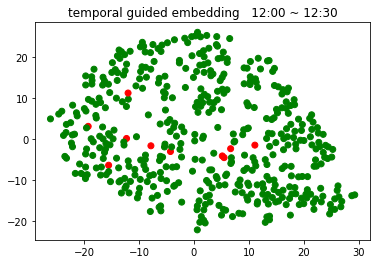

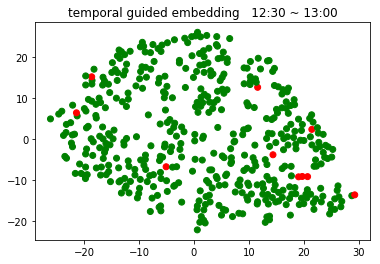

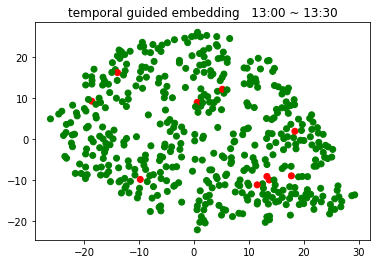

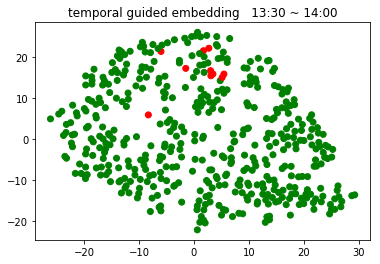

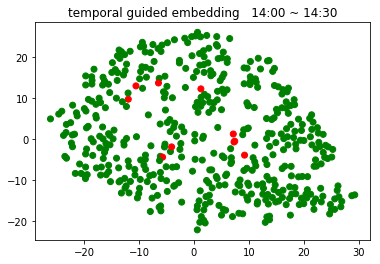

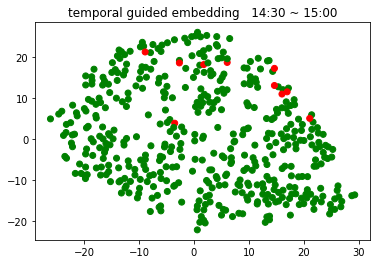

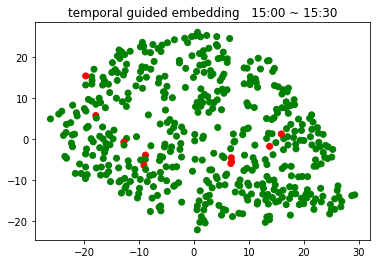

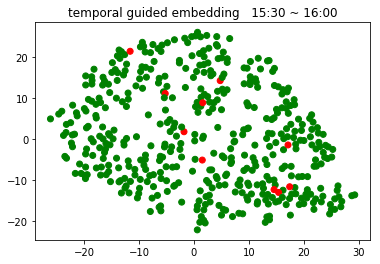

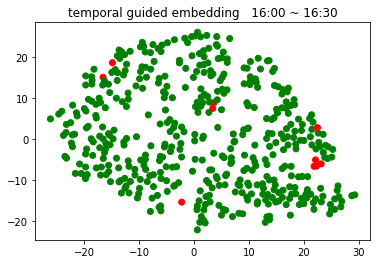

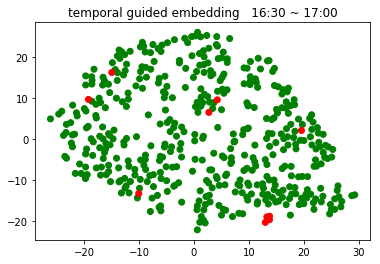

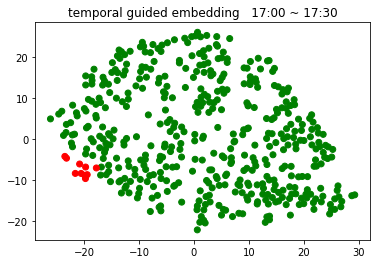

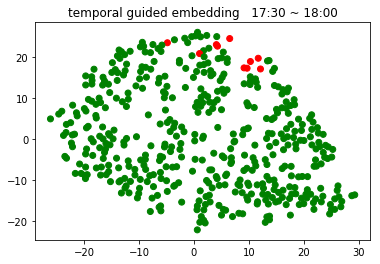

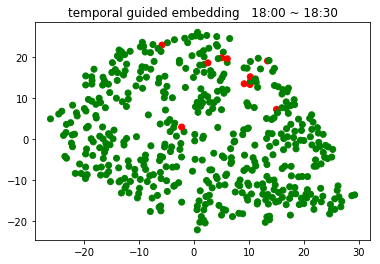

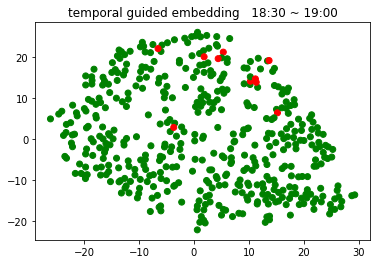

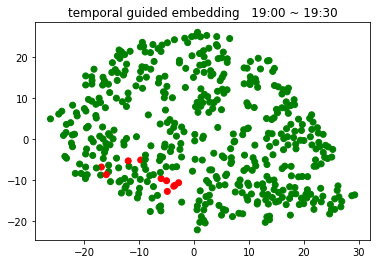

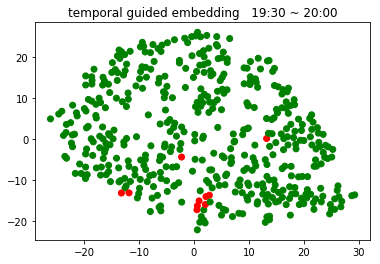

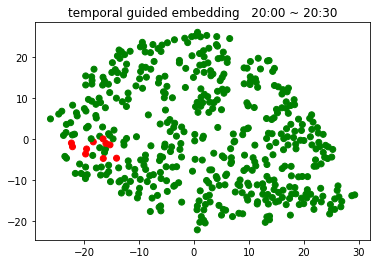

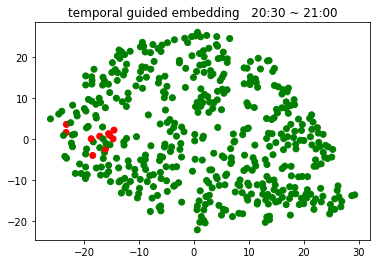

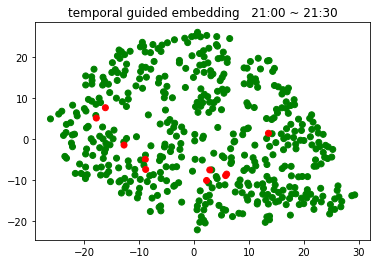

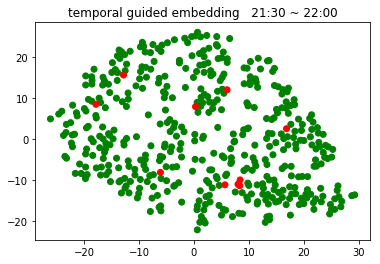

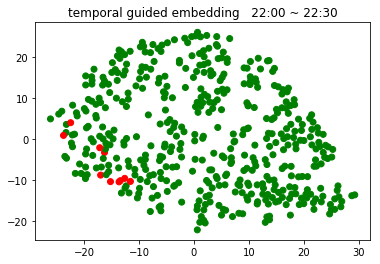

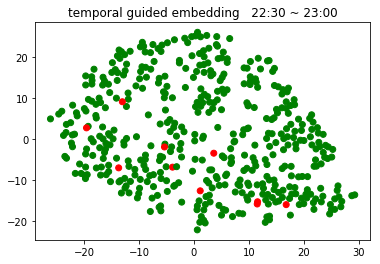

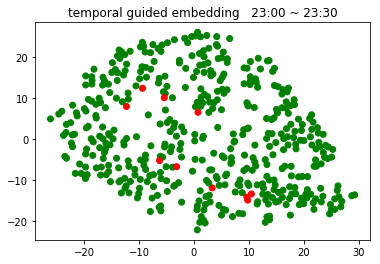

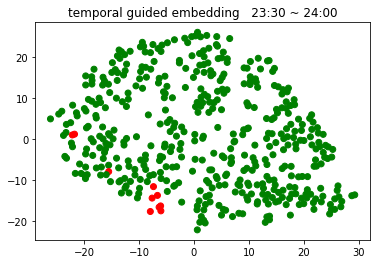

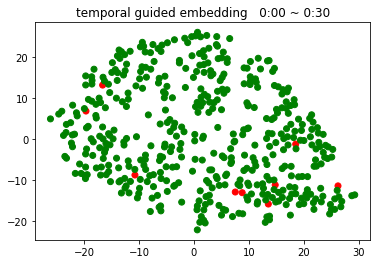

In [37]:
import os
if not os.path.exists('./tge_image_NYC'):
    os.mkdir('./tge_image_NYC')

xs = transformed[:,0]
ys = transformed[:,1]
plt.scatter(xs, ys)
plt.title('temporal guided embedding')
plt.savefig('./tge_image_NYC/0_original_image.jpg', dpi=100)
plt.show()
    
label = np.array(holiday)
for idx in range(1,49):
    i = idx%48
    temp = ['g']*48
    temp[i] = 'r'
    color = np.array(temp)
    colors = color[time_of_day]
    h = str(int(i/2))
    m = '00' if (i%2) ==0 else '30'
    next_h = str(int((i+1)/2))
    next_m = '00' if ((i+1)%2) ==0 else '30'
    plt.scatter(xs, ys, c=colors)
    plt.title('temporal guided embedding   '+h+':'+m+' ~ '+next_h+':'+next_m)
    plt.savefig('./tge_image_NYC/'+str(idx)+'temporal guided embedding   '+h+':'+m+'.jpg', dpi=500)
    plt.show()

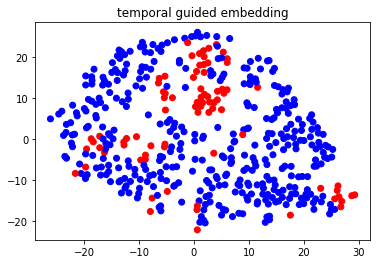

In [57]:
temp = ['b','b','r','r','b','b','b']
color = np.array(temp)
colors = color[np.array(holiday.values, dtype=np.int)]
labels = []
    
plt.scatter(xs, ys, c=colors) #, label=labels)
plt.title('temporal guided embedding')
plt.savefig('./tge_image_NYC/nyc_segmentation.jpg', dpi=1100)
#plt.legend()
plt.show()

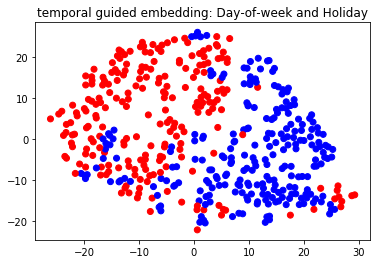

In [68]:
temp = ['b','b','r','r','b','b','b']
color = np.array(temp)
colors = color[np.array(day_of_week, dtype=np.int)]
for idx, col in enumerate(colors):
    if holiday.values[idx] == 1:
        colors[idx] = 'r'
        
labels = []
    
plt.scatter(xs, ys, c=colors) #, label=labels)
plt.title('temporal guided embedding: Day-of-week and Holiday')
plt.savefig('./tge_image_NYC/nyc_holi_weekday.jpg', dpi=1100)
#plt.legend()
plt.show()